# __Traffic Volume Prediction__
<h2 align="center"><b>Advanced Data Science Capstone Poject by</b></h2>
<h2 align="center"><b>IBM / Coursera</b></h1>
<h2 align=center>Vasilis Kokkinos (September 2019)</h2>

 ## Introduction / Business Problem

USE CASE: Predictive model of traffic volume. It can be used as template for similar situations.

DATA SET: Metro Interstate Traffic Volume Data Set
Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

Source: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume



### __Attribute Information:__

__holiday:__ Categorical US National holidays plus regional holiday, Minnesota State Fair

__temp:__ Numeric Average temp in kelvin

__rain_1h:__ Numeric Amount in mm of rain that occurred in the hour

__snow_1h:__ Numeric Amount in mm of snow that occurred in the hour

__clouds_all:__ Numeric Percentage of cloud cover

__weather_main:__ Categorical Short textual description of the current weather

__weather_description:__ Categorical Longer textual description of the current weather

__date_time:__ DateTime Hour of the data collected in local CST time

__traffic_volume:__ Numeric Hourly I-94 ATR 301 reported westbound traffic volume

------------------------------------------------------------------------------------------------------

#### __Data Cleansing__ was performed in a previous step in the notebook __traffic_volume.etl.py.v01.ipynb__

In that step:
* duplicate rows (based on the _'date_time'_ column) were removed from the data set
* the values for the _'temp'_ outliers were appropriately changed
* the row with the outlier for column _'rain_1h' was removed from the data set

The resulting data set was saved in _parquet_ format in __traffic_volume_etl_df.parquet__
    
In the current notebook, I will perform all the __Feature Creation / Transformation__ steps needed for the model definition.

--------------------------------------------------------------------------------------------

Import necessary packages, initialize Apache Spark session and add supporting functions

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('Traffic Volume Prediction').getOrCreate()
sqlContext = SQLContext(spark)
spark

Create an sql context so that we can query data files in sql like syntax

#### __Read in the data set__

In [3]:
df = spark.read.parquet('traffic_volume_etl_df.parquet')

df.createOrReplaceTempView('df')
df.printSchema()

root
 |-- holiday: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_description: string (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- traffic_volume: integer (nullable = true)



## Basic data set checks

In [4]:
df.show(20, truncate=False)

+-------+------+-------+-------+----------+------------+-----------------------+-------------------+--------------+
|holiday|temp  |rain_1h|snow_1h|clouds_all|weather_main|weather_description    |date_time          |traffic_volume|
+-------+------+-------+-------+----------+------------+-----------------------+-------------------+--------------+
|None   |280.62|0.0    |0.0    |96        |Drizzle     |light intensity drizzle|2012-10-20 03:00:00|432           |
|None   |279.24|0.0    |0.0    |1         |Clear       |sky is clear           |2012-11-16 18:00:00|5074          |
|None   |284.82|0.0    |0.0    |75        |Clouds      |broken clouds          |2012-11-22 18:00:00|3083          |
|None   |270.81|0.0    |0.0    |90        |Snow        |snow                   |2012-12-10 20:00:00|2131          |
|None   |269.47|0.0    |0.0    |20        |Clouds      |few clouds             |2012-12-14 09:00:00|5113          |
|None   |260.19|0.0    |0.0    |1         |Clear       |sky is clear    

In [5]:
print('Number of entries in the dataframe: {}'.format(df.count()))

Number of entries in the dataframe: 40569


# __Feature Engineering__

## Add month, day_of_week and hour_of_day columns
I will add columns with values of month, day and time excluding the year, because the year column should not normally have an impact on the traffic volume.

In [6]:
from pyspark.sql.functions import date_format
from pyspark.sql.types import IntegerType

df = df.withColumn('month', date_format(df['date_time'], 'M').cast(IntegerType()))
df = df.withColumn('day_of_week', date_format('date_time', 'u').cast(IntegerType()))
df = df.withColumn('hour_of_day', date_format('date_time', 'H').cast(IntegerType()))

# Refresh the temporary view of the data frame
df.createOrReplaceTempView('df')
df.show(10, truncate = False)

+-------+------+-------+-------+----------+------------+-----------------------+-------------------+--------------+-----+-----------+-----------+
|holiday|temp  |rain_1h|snow_1h|clouds_all|weather_main|weather_description    |date_time          |traffic_volume|month|day_of_week|hour_of_day|
+-------+------+-------+-------+----------+------------+-----------------------+-------------------+--------------+-----+-----------+-----------+
|None   |280.62|0.0    |0.0    |96        |Drizzle     |light intensity drizzle|2012-10-20 03:00:00|432           |10   |6          |3          |
|None   |279.24|0.0    |0.0    |1         |Clear       |sky is clear           |2012-11-16 18:00:00|5074          |11   |5          |18         |
|None   |284.82|0.0    |0.0    |75        |Clouds      |broken clouds          |2012-11-22 18:00:00|3083          |11   |4          |18         |
|None   |270.81|0.0    |0.0    |90        |Snow        |snow                   |2012-12-10 20:00:00|2131          |12   |1  

The date_time column can now be dropped.

In [7]:
df = df.drop('date_time')

# Refresh the temporary view of the data frame
df.createOrReplaceTempView('df')
df.show(20, truncate = False)

+-------+------+-------+-------+----------+------------+-----------------------+--------------+-----+-----------+-----------+
|holiday|temp  |rain_1h|snow_1h|clouds_all|weather_main|weather_description    |traffic_volume|month|day_of_week|hour_of_day|
+-------+------+-------+-------+----------+------------+-----------------------+--------------+-----+-----------+-----------+
|None   |280.62|0.0    |0.0    |96        |Drizzle     |light intensity drizzle|432           |10   |6          |3          |
|None   |279.24|0.0    |0.0    |1         |Clear       |sky is clear           |5074          |11   |5          |18         |
|None   |284.82|0.0    |0.0    |75        |Clouds      |broken clouds          |3083          |11   |4          |18         |
|None   |270.81|0.0    |0.0    |90        |Snow        |snow                   |2131          |12   |1          |20         |
|None   |269.47|0.0    |0.0    |20        |Clouds      |few clouds             |5113          |12   |5          |9    

Let's visualize the newly created columns month, day_of_week and hour_of_day to check for any irrational values

#### Function to create visually appealing boxplots

In [8]:
def create_boxplot(data, columns, size=(5, 3), title=''):
    fig = plt.figure(1, figsize=size)
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data)
    bp = ax.boxplot(data, patch_artist=True)

    for box in bp['boxes']:
        # change outline color
        box.set(color='#7570b3', linewidth=2)
        # change fill color
        box.set(facecolor = '#1e3aab')

    for whisker in bp['whiskers']:
        whisker.set(color='#7570b3', linewidth=2)

    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#b2df8a', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)

    # Change x-axis labels and remove tick marks from the top and right axes.
    ## Custom x-axis labels
    ax.set_xticklabels(columns)

    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    ax.set_title(title)

    plt.show()

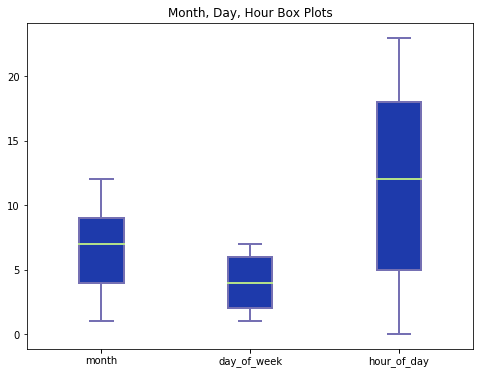

In [9]:
# Since the number of rows in the dataframe is not too high, we can afford to use ALL the data points
result1 = spark.sql('select month from df').rdd.map(lambda row: row.month).sample(False, 0.99).collect()
result2 = spark.sql('select day_of_week from df').rdd.map(lambda row: row.day_of_week).sample(False, 0.99).collect()
result3 = spark.sql('select hour_of_day from df').rdd.map(lambda row: row.hour_of_day).sample(False, 0.99).collect()
data = np.array([result1, result2, result3])

create_boxplot(data, ['month', 'day_of_week', 'hour_of_day'], size=(8, 6), title='Month, Day, Hour Box Plots')

The values of the three columns all make sense and there are no outliers

## Transform the values of the columns 'holiday', 'weather_main', 'weather_description' to indexes

In [10]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="holiday", outputCol="holidayIndex")
df = indexer.fit(df).transform(df)
indexer = StringIndexer(inputCol="weather_main", outputCol="weatherMainIndex")
df = indexer.fit(df).transform(df)
indexer = StringIndexer(inputCol="weather_description", outputCol="weatherDescIndex")
df = indexer.fit(df).transform(df)

# Refresh the temporary view of the data frame
df.createOrReplaceTempView('df')
df.printSchema()

root
 |-- holiday: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_description: string (nullable = true)
 |-- traffic_volume: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- holidayIndex: double (nullable = false)
 |-- weatherMainIndex: double (nullable = false)
 |-- weatherDescIndex: double (nullable = false)



Let's cast the three new colums to integers

In [11]:
df = df.withColumn('holidayIndex', df['holidayIndex'].cast(IntegerType()))
df = df.withColumn('weatherMainIndex', df['weatherMainIndex'].cast(IntegerType()))
df = df.withColumn('weatherDescIndex', df['weatherDescIndex'].cast(IntegerType()))

# Refresh the temporary view of the data frame
df.createOrReplaceTempView('df')
df.printSchema()

root
 |-- holiday: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- snow_1h: double (nullable = true)
 |-- clouds_all: integer (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_description: string (nullable = true)
 |-- traffic_volume: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- holidayIndex: integer (nullable = true)
 |-- weatherMainIndex: integer (nullable = true)
 |-- weatherDescIndex: integer (nullable = true)



In [12]:
df.show(20, truncate=False)

+-------+------+-------+-------+----------+------------+-----------------------+--------------+-----+-----------+-----------+------------+----------------+----------------+
|holiday|temp  |rain_1h|snow_1h|clouds_all|weather_main|weather_description    |traffic_volume|month|day_of_week|hour_of_day|holidayIndex|weatherMainIndex|weatherDescIndex|
+-------+------+-------+-------+----------+------------+-----------------------+--------------+-----+-----------+-----------+------------+----------------+----------------+
|None   |280.62|0.0    |0.0    |96        |Drizzle     |light intensity drizzle|432           |10   |6          |3          |0           |6               |10              |
|None   |279.24|0.0    |0.0    |1         |Clear       |sky is clear           |5074          |11   |5          |18         |0           |1               |0               |
|None   |284.82|0.0    |0.0    |75        |Clouds      |broken clouds          |3083          |11   |4          |18         |0         

__Before we drop the 'String' columns 'holiday', 'weather_main' and 'weather_description' let's see how their values were mapped by the StringIndexer__

First the __'holiday'__ column

In [13]:
spark.sql('select holiday, holidayIndex, count(*) as count from df group by holiday, holidayIndex order by holidayIndex').show(50, False)

+-------------------------+------------+-----+
|holiday                  |holidayIndex|count|
+-------------------------+------------+-----+
|None                     |0           |40516|
|Labor Day                |1           |5    |
|Thanksgiving Day         |2           |5    |
|Independence Day         |3           |5    |
|State Fair               |4           |5    |
|Veterans Day             |5           |5    |
|Columbus Day             |6           |5    |
|New Years Day            |7           |5    |
|Christmas Day            |8           |5    |
|Washingtons Birthday     |9           |5    |
|Memorial Day             |10          |5    |
|Martin Luther King Jr Day|11          |3    |
+-------------------------+------------+-----+



Next the __'weather_main'__ column

In [14]:
spark.sql('select weather_main, weatherMainIndex, count(*) as count from df group by weather_main, weatherMainIndex order by weatherMainIndex').show(50, False)

+------------+----------------+-----+
|weather_main|weatherMainIndex|count|
+------------+----------------+-----+
|Clouds      |0               |15121|
|Clear       |1               |13366|
|Rain        |2               |3857 |
|Mist        |3               |3648 |
|Snow        |4               |1924 |
|Haze        |5               |852  |
|Drizzle     |6               |844  |
|Thunderstorm|7               |537  |
|Fog         |8               |411  |
|Smoke       |9               |8    |
|Squall      |10              |1    |
+------------+----------------+-----+



And finally for the __'weather_description'__ column

In [15]:
spark.sql('select weather_description, weatherDescIndex, count(*) as count from df group by weather_description, weatherDescIndex order by weatherDescIndex').show(50, False)

+-----------------------------------+----------------+-----+
|weather_description                |weatherDescIndex|count|
+-----------------------------------+----------------+-----+
|sky is clear                       |0               |13366|
|overcast clouds                    |1               |5072 |
|broken clouds                      |2               |4649 |
|mist                               |3               |3648 |
|scattered clouds                   |4               |3455 |
|light rain                         |5               |2480 |
|few clouds                         |6               |1945 |
|light snow                         |7               |1406 |
|moderate rain                      |8               |1031 |
|haze                               |9               |852  |
|light intensity drizzle            |10              |537  |
|fog                                |11              |411  |
|heavy snow                         |12              |378  |
|proximity thunderstorm 

__Now, let's drop the three columns__

In [16]:
df = df.drop('holiday').drop('weather_main').drop('weather_description')

# Refresh the temporary view of the data frame
df.createOrReplaceTempView('df_temp')
df.show(20, truncate = False)

+------+-------+-------+----------+--------------+-----+-----------+-----------+------------+----------------+----------------+
|temp  |rain_1h|snow_1h|clouds_all|traffic_volume|month|day_of_week|hour_of_day|holidayIndex|weatherMainIndex|weatherDescIndex|
+------+-------+-------+----------+--------------+-----+-----------+-----------+------------+----------------+----------------+
|280.62|0.0    |0.0    |96        |432           |10   |6          |3          |0           |6               |10              |
|279.24|0.0    |0.0    |1         |5074          |11   |5          |18         |0           |1               |0               |
|284.82|0.0    |0.0    |75        |3083          |11   |4          |18         |0           |0               |2               |
|270.81|0.0    |0.0    |90        |2131          |12   |1          |20         |0           |4               |16              |
|269.47|0.0    |0.0    |20        |5113          |12   |5          |9          |0           |0          

### Save the data frame in __parquet__ format for future use

In [17]:
df = df.repartition(1)
df.write.parquet('traffic_volume_feature_eng_df.parquet')

## __Summary__

We now have a final transformed data frame that we can use to create the prediction model for the traffic volume.

The data frame is saved in __parquet__ format and is ready to be consumed for the model definition, traininng and testing.